# Step 1

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lyrics_df = pd.read_csv('../dataset/scraped_lyrics.csv')
lyrics = lyrics_df['Lyrics'].tolist()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)
bert_model.eval()

def get_text_embedding(text):
  inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
  inputs = {key: val.to(device) for key, val in inputs.items()}
  with torch.no_grad():
    outputs = bert_model(**inputs)
    last_hidden_state = outputs.last_hidden_state
  embedding = torch.mean(last_hidden_state, dim=1)
  return embedding.squeeze().cpu().numpy()

text_embeddings = []
for idx, lyric in enumerate(lyrics):
  embedding = get_text_embedding(lyric)
  text_embeddings.append(embedding)
  if (idx + 1) % 50 == 0:
    print(f'Processed {idx + 1}/{len(lyrics)} songs')

text_embeddings = np.stack(text_embeddings)

class LyricDataset(Dataset):
  def __init__(self, embeddings):
    self.embeddings = embeddings

  def __len__(self):
    return len(self.embeddings)

  def __getitem__(self, idx):
    embedding = self.embeddings[idx]
    noisy_embedding = embedding + np.random.normal(0, 0.1, embedding.shape)
    return torch.tensor(noisy_embedding, dtype=torch.float32), torch.tensor(embedding, dtype=torch.float32)

dataset = LyricDataset(text_embeddings)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class NoiseReductionAutoencoder(nn.Module):
  def __init__(self, input_dim, hidden_dim1, hidden_dim2):
    super(NoiseReductionAutoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim1),
        nn.ReLU(),
        nn.Linear(hidden_dim1, hidden_dim2),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(hidden_dim2, hidden_dim1),
        nn.ReLU(),
        nn.Linear(hidden_dim1, input_dim)
    )

  def forward(self, x):
    latent_representation = self.encoder(x)
    reconstructed_embedding = self.decoder(latent_representation)
    return reconstructed_embedding

embedding_size = text_embeddings.shape[1]
latent_dim1 = 512
latent_dim2 = 256

model = NoiseReductionAutoencoder(embedding_size, latent_dim1, latent_dim2).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  total_loss = 0
  for noisy_embedding, clean_embedding in dataloader:
    noisy_embedding = noisy_embedding.to(device)
    clean_embedding = clean_embedding.to(device)
    optimizer.zero_grad()
    reconstructed_embedding = model(noisy_embedding)
    loss = loss_function(reconstructed_embedding, clean_embedding)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  avg_loss = total_loss / len(dataloader)
  print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

c:\Users\ramel\Desktop\INSPER\24.2\NLP\APS_EMBEDDING\APS_EMBEDDING_NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


cuda
Processed 50/31818 songs
Processed 100/31818 songs
Processed 150/31818 songs
Processed 200/31818 songs
Processed 250/31818 songs
Processed 300/31818 songs
Processed 350/31818 songs
Processed 400/31818 songs
Processed 450/31818 songs
Processed 500/31818 songs
Processed 550/31818 songs
Processed 600/31818 songs
Processed 650/31818 songs
Processed 700/31818 songs
Processed 750/31818 songs
Processed 800/31818 songs
Processed 850/31818 songs
Processed 900/31818 songs
Processed 950/31818 songs
Processed 1000/31818 songs
Processed 1050/31818 songs
Processed 1100/31818 songs
Processed 1150/31818 songs
Processed 1200/31818 songs
Processed 1250/31818 songs
Processed 1300/31818 songs
Processed 1350/31818 songs
Processed 1400/31818 songs
Processed 1450/31818 songs
Processed 1500/31818 songs
Processed 1550/31818 songs
Processed 1600/31818 songs
Processed 1650/31818 songs
Processed 1700/31818 songs
Processed 1750/31818 songs
Processed 1800/31818 songs
Processed 1850/31818 songs
Processed 1900/3

In [ ]:

torch.save(model.state_dict(), 'autoencoder.pth')


# Step 2

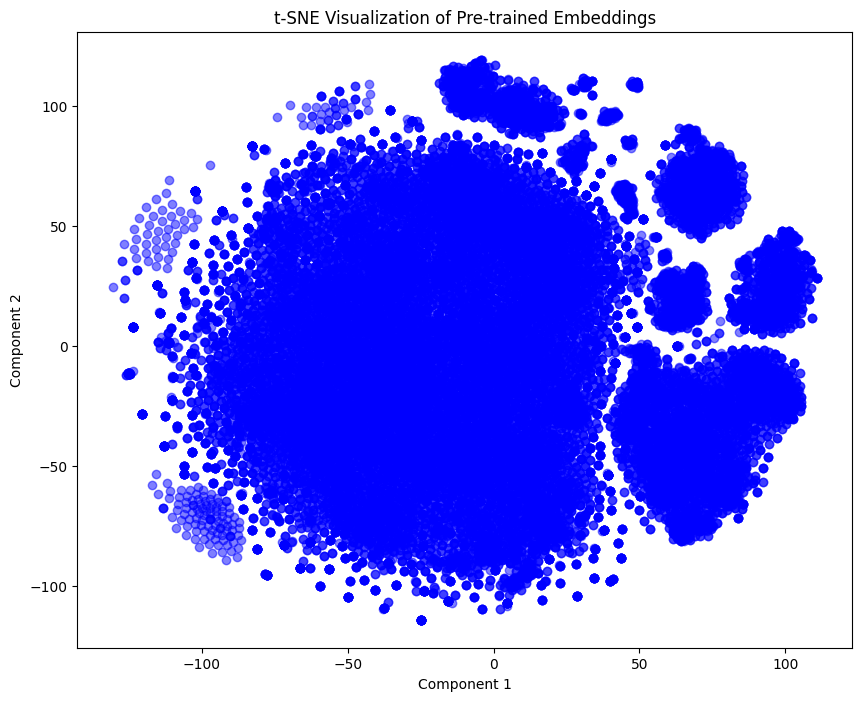

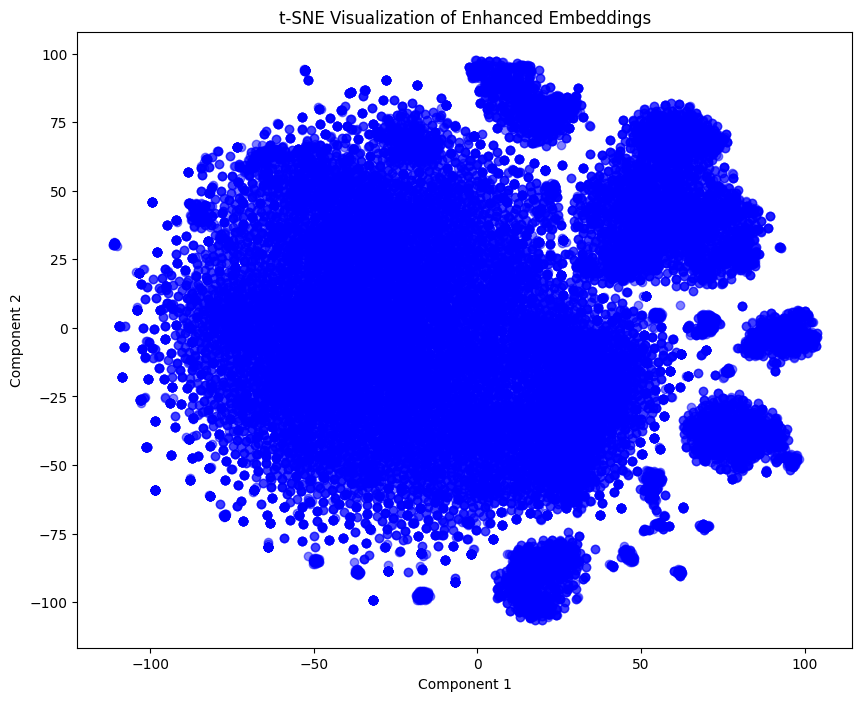

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

original_vectors = text_embeddings  
advanced_vectors = np.load('enhanced_embeddings.npy')

reducer_pretrained = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_pretrained = reducer_pretrained.fit_transform(original_vectors)

reducer_enhanced = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_enhanced = reducer_enhanced.fit_transform(advanced_vectors)

data_labels = ['Song'] * len(reduced_pretrained)

def visualize_projections(projections, title):
    plt.figure(figsize=(10, 8))
    x_coords = projections[:, 0]
    y_coords = projections[:, 1]
    plt.scatter(x_coords, y_coords, c='blue', alpha=0.5)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

visualize_projections(reduced_pretrained, 't-SNE Visualization of Original Embeddings')
visualize_projections(reduced_enhanced, 't-SNE Visualization of Advanced Embeddings')


# Step 3

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from langdetect import detect, LangDetectException
import re  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



def clean_text(text):
   
    text = text.lower()
   
    text = re.sub(r'[^a-z0-9\s]', '', text)
    
    text = re.sub(r'\s+', ' ', text)
    
    text = text.strip()
    return text


df = pd.read_csv('../dataset/scraped_lyrics.csv')


df['Cleaned Lyrics'] = df['Lyrics'].apply(clean_text)


df = df[df['Cleaned Lyrics'].str.len() > 20]


def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'


df['Language'] = df['Cleaned Lyrics'].apply(detect_language)
df = df[df['Language'] == 'en']  


sbert_model = SentenceTransformer('all-mpnet-base-v2')


lyrics_list = df['Cleaned Lyrics'].tolist()
embeddings = sbert_model.encode(lyrics_list, convert_to_numpy=True)


def get_query_embedding(query):
    
    query = clean_text(query)
    return sbert_model.encode(query, convert_to_numpy=True)


def search(query, top_k=10):
    query_embedding = get_query_embedding(query)
    similarities = cosine_similarity([query_embedding], embeddings)[0]
  
    sorted_indices = similarities.argsort()[::-1]
    results = []
    titles = set()
    for idx in sorted_indices:
        title = df.iloc[idx]['Song Name']
        if title not in titles:
            results.append({
                'Song Name': title,
                'Similarity': similarities[idx],
                'Lyrics': df.iloc[idx]['Lyrics']
            })
            titles.add(title)
        if len(results) == top_k:
            break
    return pd.DataFrame(results)


query1 = "love and heartbreak"
results1 = search(query1, top_k=10)
print("Test Results with SBERT, Language Filtering, and Preprocessing:")
print(results1[['Song Name', 'Similarity']])



cuda
Test Results with SBERT, Language Filtering, and Preprocessing:
                        Song Name  Similarity
0                        The Rose    0.593315
1                 With Or Without    0.581248
2                    Get Together    0.580406
3  What Is This Thing Called Love    0.575974
4             Hands Off the Wheel    0.570333
5         Love Will Tear Us Apart    0.560208
6                          MMMBop    0.550839
7             Something About You    0.549870
8                 It Would Be You    0.532923
9                   Brand New Day    0.532534


In [ ]:

query2 = "antidisestablishmentarianism"
results2 = search(query2, top_k=10)

threshold = 0.5
filtered_results2 = results2[results2['Similarity'] >= threshold]
print("\nTest 2 Results:")
print(filtered_results2[['Song Name', 'Similarity']])



Test 2 Results:
                            Song Name  Similarity
0  Supercalifragilisticexpialidocious    0.511443


In [ ]:

query3 = "time travel paradox"
results3 = search(query3, top_k=10)
print("\nTest 3 Results:")
print(results3[['Song Name', 'Similarity']])



Test 3 Results:
                          Song Name  Similarity
0               Tribute to the Past    0.468967
1  Spending Time [Multimedia Track]    0.422412
2          Where Do We Go From Here    0.396293
3                     Another Space    0.395179
4                     Absolute Zero    0.385202
5                  Time in a Bottle    0.372783
6              Time Travel in Texas    0.359476
7                Invisible Horizons    0.350368
8                        Golden Age    0.349256
9            Mother Shipton's Words    0.345966
